### **CS6501 - MACHINE LEARNING AND APPLICATIONS**
#### **NOTEBOOK-5: Baseline Modeling & Feature Selection**

**Description:**  
This notebook experiments with building an explainable baseline regression model for BER prediction using a Voting Regressor ensemble of Random Forest, XGBoost, and CatBoost.

#### --- Library Imports ---

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#### --- Load Cleaned Dataset ---

In [2]:
# Load the cleaned BER dataset
df = pd.read_csv('../dataset/BERPublicSearch_Cleaned.csv')  
print(f"Dataset shape: {df.shape}")

Dataset shape: (80000, 101)


#### --- Load Feature Importance Ranking ---

In [3]:
# Load the feature importance ranking
feature_importance = pd.read_csv('../dataset/BER_feature_importance.csv')  
print(f"Feature importance shape: {feature_importance.shape}")

Feature importance shape: (98, 16)


#### --- Stratify 30k sample ---

In [4]:
# Create bins for stratification
num_bins = 10
df['BER_bin'] = pd.qcut(df['BerRating'], q=num_bins, duplicates='drop')

# Stratified sample of 30k from ~80k
sample_size = 30_000
df, _ = train_test_split(
    df,
    train_size=sample_size,
    stratify=df['BER_bin'],
    random_state=42
)

print("Stratified 30k sample created with shape:", df.shape)

Stratified 30k sample created with shape: (30000, 102)


#### --- Ranking and Cumulative Contribution of Features ---
We sort the features by their importance (`FinalScore`) in descending order, then compute the cumulative sum and cumulative percentage of these scores. 
This helps visualize how much each feature contributes to the total importance and identify the most influential features.  

In [5]:
# Sort features descending by FinalScore
feature_importance_sorted = feature_importance.sort_values('FinalScore', ascending=False)

# Compute cumulative sum
feature_importance_sorted['cumulative_score'] = feature_importance_sorted['FinalScore'].cumsum()

# Compute cumulative percentage
feature_importance_sorted['cumulative_score_pct'] = 100 * feature_importance_sorted['cumulative_score'] / feature_importance_sorted['FinalScore'].sum()

In [6]:
feature_importance_sorted

,BaseFeature,RF_Importance,GB_Importance,Lasso_Importance,RF_Importance_scaled,GB_Importance_scaled,Lasso_Importance_scaled,RF_Weighted,GB_Weighted,Lasso_Weighted,VotingScore,feature_name,category,availability,AvailabilityBoost,FinalScore,cumulative_score,cumulative_score_pct
0,UValueWall,0.382409,0.325064,0.000000,1.000000,1.000000,0.0,0.949447,0.953309,0.000000,0.634252,UValueWall,Envelope,medium,1.05,0.665965,0.665965,29.303158
1,GroundFloorArea(sq m),0.017468,0.029279,0.720533,0.045672,0.090071,1.0,0.043363,0.085866,0.803015,0.310748,GroundFloorArea(sq m),Geometry,easy,1.15,0.357360,1.023325,45.027390
2,DeclaredLossFactor,0.192400,0.126905,0.000000,0.503123,0.390401,0.0,0.477689,0.372173,0.000000,0.283287,DeclaredLossFactor,Heating,hard,1.00,0.283287,1.306612,57.492334
3,UValueRoof,0.046948,0.072842,0.000000,0.122763,0.224086,0.0,0.116557,0.213623,0.000000,0.110060,UValueRoof,Envelope,medium,1.05,0.115563,1.422175,62.577230
4,UValueFloor,0.030211,0.077380,0.000000,0.078995,0.238046,0.0,0.075002,0.226931,0.000000,0.100644,UValueFloor,Envelope,medium,1.05,0.105677,1.527852,67.227112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,CountyName,0.000026,0.000000,0.000000,0.000062,0.000000,0.0,0.000059,0.000000,0.000000,0.000020,CountyName,Geometry,easy,1.15,0.000022,2.272644,99.998789
94,TypeofRating,0.000016,0.000000,0.000000,0.000034,0.000000,0.0,0.000032,0.000000,0.000000,0.000011,TypeofRating,Geometry,easy,1.15,0.000012,2.272657,99.999336
95,FanPowerManuDeclaredValue,0.000014,0.000000,0.000000,0.000031,0.000000,0.0,0.000029,0.000000,0.000000,0.000010,FanPowerManuDeclaredValue,Heating,hard,1.00,0.000010,2.272667,99.999767
96,StructureType,0.000008,0.000000,0.000000,0.000015,0.000000,0.0,0.000014,0.000000,0.000000,0.000005,StructureType,Geometry,easy,1.15,0.000005,2.272672,100.000000


#### --- Selecting Top Features Based on Cumulative Importance ---
We define thresholds for the cumulative percentage of feature importance and select the top features contributing up to each threshold.  
This generates subsets of features representing 95%, 96%, 97%, 98%, 99%, and 100% of total importance, helping us analyze performance vs. number of features.

In [7]:
# Define thresholds for cumulative score pct
thresholds = [95,96,97,98,99,100]
top_n_subsets = []
num_features_per_subset = []

for t in thresholds:
    top_features = feature_importance_sorted[feature_importance_sorted['cumulative_score_pct'] <= t]['feature_name'].tolist()
    top_n_subsets.append(top_features)
    num_features_per_subset.append(len(top_features))
    print(f"Threshold {t}% cumulative score -> {len(top_features)} features: {top_features}")
    print("--------------------------------------------------------------------------------")

Threshold 95% cumulative score -> 21 features: ['UValueWall', 'GroundFloorArea(sq m)', 'DeclaredLossFactor', 'UValueRoof', 'UValueFloor', 'TempAdjustment', 'DeliveredEnergyPumpsFans', 'HSMainSystemEfficiency', 'DistributionLosses', 'TempFactorMultiplier', 'UValueWindow', 'HeatSystemResponseCat', 'PrimaryEnergyMainSpace', 'CO2MainSpace', 'FirstFloorArea', 'FirstEnerProdDelivered', 'WHMainSystemEff', 'DeliveredEnergyMainSpace', 'Year_of_Construction', 'PrimaryEnergyMainWater', 'PrimaryEnergySecondarySpace']
--------------------------------------------------------------------------------
Threshold 96% cumulative score -> 24 features: ['UValueWall', 'GroundFloorArea(sq m)', 'DeclaredLossFactor', 'UValueRoof', 'UValueFloor', 'TempAdjustment', 'DeliveredEnergyPumpsFans', 'HSMainSystemEfficiency', 'DistributionLosses', 'TempFactorMultiplier', 'UValueWindow', 'HeatSystemResponseCat', 'PrimaryEnergyMainSpace', 'CO2MainSpace', 'FirstFloorArea', 'FirstEnerProdDelivered', 'WHMainSystemEff', 'Deliv

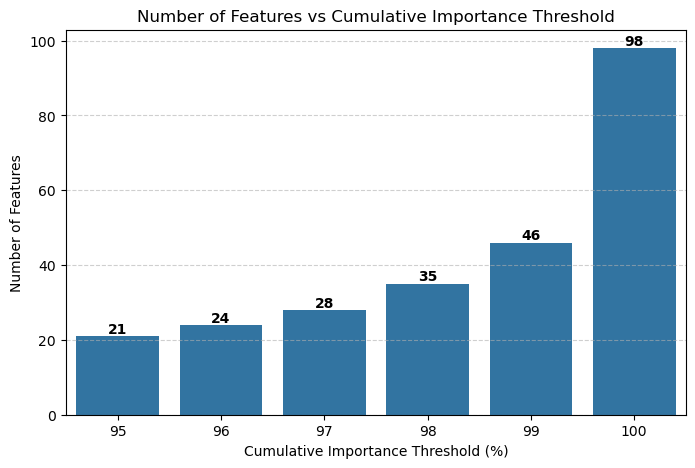

In [8]:
# Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x=thresholds, y=num_features_per_subset)

# Add value labels on top of bars
for i, v in enumerate(num_features_per_subset):
    plt.text(i, v + 0.8, str(v), ha='center', fontweight='bold')

plt.xlabel('Cumulative Importance Threshold (%)')
plt.ylabel('Number of Features')
plt.title('Number of Features vs Cumulative Importance Threshold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

#### --- **Model: Voting Regressor with RF, XGB, and CatBoost** ---

We plan to use a **Voting Regressor** as the final ensemble model, combining three powerful base regressors:

- **Random Forest (RF):** Handles non-linear relationships, robust to overfitting, and provides good baseline performance.  
- **XGBoost (XGB):** Gradient boosting model that captures complex patterns efficiently and often improves accuracy over single models.  
- **CatBoost:** Handles categorical features effectively, reduces the need for extensive preprocessing, and performs well on tabular data.

For now, with these **basic hyperparameter settings**, we will run the voting model for each feature subset to identify the **minimal feature subset** that achieves strong predictive performance.


In [9]:
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

In [10]:
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.0,
    eval_metric='rmse',
    random_state=42
)

In [11]:
cat_model = CatBoostRegressor(
    iterations=400,
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_state=42,
    verbose=False
)

In [12]:
voting_model = VotingRegressor(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('cat', cat_model)
    ]
)

In [13]:
subset_results = []   # will store metrics for each subset

In [14]:
X = df.drop(columns=['BerRating', 'EnergyRating','MPCDERValue'])
y = df['BerRating']

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#### --- Evaluating Voting Regressor on Each Feature Subset ---
We evaluate the Voting Regressor on each feature subset derived from the cumulative importance thresholds. The model is then trained on the training set, and predictions are made on the validation set. Performance metrics including RMSE, R², and MAE are computed and stored to compare how the number of features affects model accuracy, helping identify the minimal subset that achieves strong predictive performance.

In [16]:

for idx, feature_list in enumerate(top_n_subsets):

    print(f"--- Running subset {idx+1} with {len(feature_list)} features ---")

    # select only the required features
    X_train_sub = X_train[feature_list]
    X_val_sub = X_val[feature_list]

    # identify categorical columns
    cat_cols = X_train_sub.select_dtypes(include='object').columns.tolist()

    if cat_cols:
        # one-hot encode categorical features
        X_train_sub = pd.get_dummies(X_train_sub, columns=cat_cols)
        X_val_sub = pd.get_dummies(X_val_sub, columns=cat_cols)

        # align columns to ensure train and val have same dummy columns
        X_val_sub = X_val_sub.reindex(columns=X_train_sub.columns, fill_value=0)

    # fit the voting regressor
    voting_model.fit(X_train_sub, y_train)

    # predictions
    preds = voting_model.predict(X_val_sub)

    # compute metrics
    rmse = mean_squared_error(y_val, preds) ** 0.5   # manual RMSE
    r2 = r2_score(y_val, preds)
    mae = mean_absolute_error(y_val, preds)

    # store results
    subset_results.append({
        'subset_id': idx+1,
        'num_features': len(feature_list),
        'features': feature_list,
        'rmse': rmse,
        'r2': r2,
        'mae': mae
    })

--- Running subset 1 with 21 features ---
--- Running subset 2 with 24 features ---
--- Running subset 3 with 28 features ---
--- Running subset 4 with 35 features ---
--- Running subset 5 with 46 features ---
--- Running subset 6 with 98 features ---


In [17]:
subset_results_df = pd.DataFrame(subset_results)

In [18]:
subset_results_df

,subset_id,num_features,features,rmse,r2,mae
0,1,21,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",22.490783,0.974478,13.200021
1,2,24,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",21.717080,0.976204,12.530099
2,3,28,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",21.900572,0.975800,12.638958
3,4,35,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",21.809417,0.976001,12.470326
4,5,46,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",21.820608,0.975977,12.568051
5,6,98,"[UValueWall, GroundFloorArea(sq m), DeclaredLo...",21.720646,0.976196,12.382798


#### --- Plots to understand ---

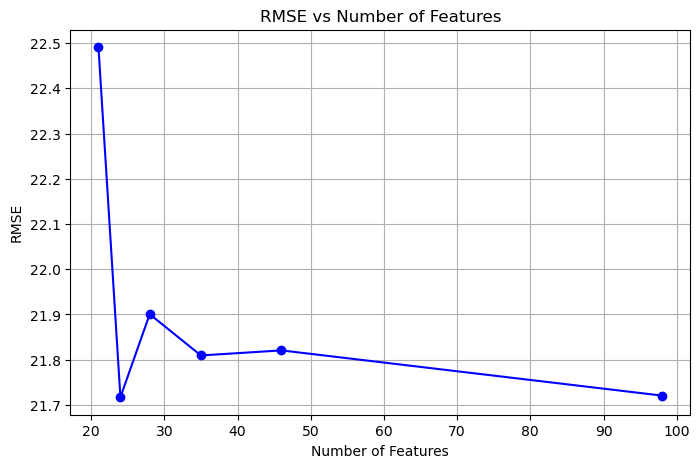

In [20]:
plt.figure(figsize=(8,5))
plt.plot(subset_results_df['num_features'], subset_results_df['rmse'], marker='o', color='blue')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs Number of Features')
plt.grid(True)
plt.show()

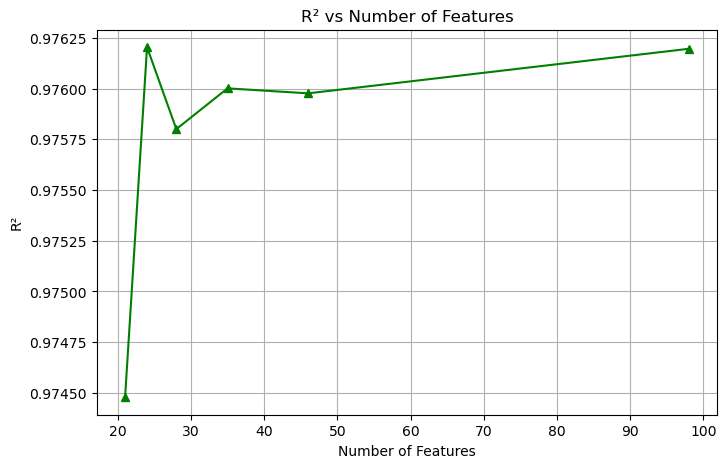

In [21]:
# R² vs Number of Features
plt.figure(figsize=(8,5))
plt.plot(subset_results_df['num_features'], subset_results_df['r2'], marker='^', color='green')
plt.xlabel('Number of Features')
plt.ylabel('R²')
plt.title('R² vs Number of Features')
plt.grid(True)
plt.show()

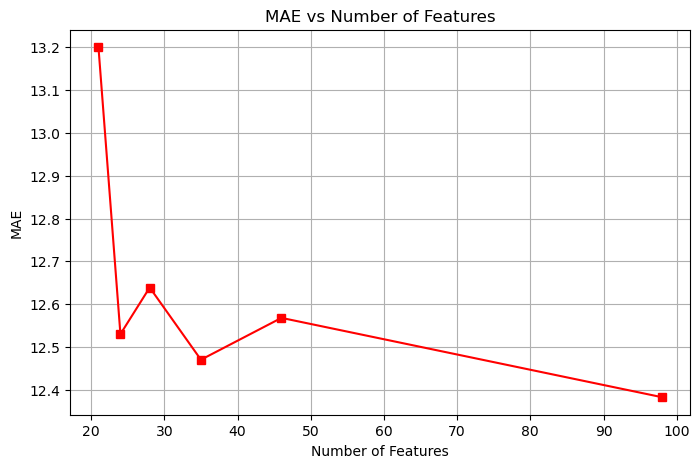

In [22]:
plt.figure(figsize=(8,5))
plt.plot(subset_results_df['num_features'], subset_results_df['mae'], marker='s', color='red')
plt.xlabel('Number of Features')
plt.ylabel('MAE')
plt.title('MAE vs Number of Features')
plt.grid(True)
plt.show()

In [26]:
# Selected features
subset_2_features = subset_results_df.loc[subset_results_df['subset_id'] == 2, 'features'].values[0]
print(subset_2_features)

['UValueWall', 'GroundFloorArea(sq m)', 'DeclaredLossFactor', 'UValueRoof', 'UValueFloor', 'TempAdjustment', 'DeliveredEnergyPumpsFans', 'HSMainSystemEfficiency', 'DistributionLosses', 'TempFactorMultiplier', 'UValueWindow', 'HeatSystemResponseCat', 'PrimaryEnergyMainSpace', 'CO2MainSpace', 'FirstFloorArea', 'FirstEnerProdDelivered', 'WHMainSystemEff', 'DeliveredEnergyMainSpace', 'Year_of_Construction', 'PrimaryEnergyMainWater', 'PrimaryEnergySecondarySpace', 'PrimaryEnergyPumpsFans', 'NoStoreys', 'PrimaryEnergySupplementaryWater']


**Summary:**

- Subset 2, with **24 features**, achieves **RMSE = 21.72, R² = 0.9762, and MAE = 12.53**, which is the best trade-off between performance and simplicity.  
- Subset 1 (21 features) has slightly worse performance: RMSE = 22.49, R² = 0.9745, MAE = 13.20.  
- Adding more features beyond 24 (Subsets 3–6) provides **minimal improvement**: for example, Subset 6 (98 features) has RMSE = 21.72, R² = 0.9762, MAE = 12.38, almost the same as Subset 2.  
- Therefore, Subset 2 is chosen for the final model because it **maintains high predictive accuracy with fewer features**, reducing complexity and risk of overfitting while keeping the model interpretable.
